In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import dsbmm_bp.simulation as dsbmm_sim


In [2]:
Q = 4
T = 5
N = 100
Z_1 = np.random.randint(0, Q, size=(N,))
meta_types = ["poisson", "indep bernoulli"]
L = 5
meta_params = [np.random.randint(5, 15, size=(1, Q, T)), np.random.rand(L, Q, T)]

dsbmm_dict = dsbmm_sim.sample_dynsbm_meta(
    Z_1=Z_1, Q=Q, T=T, meta_types=meta_types, meta_dims=[1, L], meta_params=meta_params
)



In [3]:
from dsbmm_bp.utils import nb_ari_local
# sanity check that ari doesn't just provide 1s 
print(nb_ari_local(dsbmm_dict['Z'],np.random.randint(0,Q,size=dsbmm_dict['Z'].shape)))

[-0.00629305  0.00587689 -0.00881727 -0.01216677  0.02248357]


In [105]:
A = dsbmm_dict['A']

In [109]:
np.array(list(map(np.count_nonzero, A.transpose(2, 0, 1))))

array([1934, 1633, 1576, 1493, 1385])

In [113]:
from numba import typeof,float32
from numba.typed import List 
from numba.types import ListType
typeof([[np.array([1,2])]])
tmp = List.empty_list(ListType(float32[:]))

In [122]:
a = np.ones((10,4))
b = np.ones((10,4))
np.outer(a,b).shape

(40, 40)

In [11]:
test = np.random.rand(5,4,3,3,2)
test /= test.sum(axis=3)[:,:,:,np.newaxis,:]
test.sum(axis=3)[0,0,:,0]

array([1., 1., 1.])

In [8]:
test = np.random.rand(5,4)
test /= test.sum(axis=1)[:,np.newaxis]
test.sum(axis=1)

array([1., 1., 1., 1., 1.])

In [43]:
import numpy as np
from numba import njit  

test_marg = np.random.rand(10,5,4)
test_beta = np.random.rand(4,4,5)
np.allclose((test_beta.transpose(1,0,2) * test_marg.sum(axis=0).T).sum(axis=1),np.einsum("itr,rqt->qt", test_marg, test_beta))
# test = np.random.rand(10,10,3) > 0.2
# @njit
# def test_fun(test):
#     def get_neighbours(A):
#         edge_locs = np.array(list(zip(*A.nonzero())))
#         return edge_locs
#     edge_locs = get_neighbours(test)
#     for i,j,t in edge_locs:
#         print(i,j,t) 
# test_fun(test)

True

In [44]:
@njit(cache=True)
def nb_ib_lkl(xs, ps):
    """Calculate IB lkl of observing xs given probs ps

    Args:
        xs (_type_): _description_
        ps (_type_): _description_

    Returns:
        _type_: _description_
    """
    # assume L dim vecs passed for each
    return np.prod(np.power(ps, xs)) * np.prod(np.power(1 - ps, 1 - xs))

from numba.experimental import jitclass 

from numba import prange
@njit(fastmath=True, error_model="numpy", parallel=True)
def gammaln_nb_p_vec(z):
    # """Numerical Recipes 6.1
    # Code from https://stackoverflow.com/questions/55048299/why-is-this-log-gamma-numba-function-slower-than-scipy-for-large-arrays-but-fas"""
    # Don't use global variables.. (They only can be changed if you recompile the function)
    print(1)
    coefs = np.array(
        [
            57.1562356658629235,
            -59.5979603554754912,
            14.1360979747417471,
            -0.491913816097620199,
            0.339946499848118887e-4,
            0.465236289270485756e-4,
            -0.983744753048795646e-4,
            0.158088703224912494e-3,
            -0.210264441724104883e-3,
            0.217439618115212643e-3,
            -0.164318106536763890e-3,
            0.844182239838527433e-4,
            -0.261908384015814087e-4,
            0.368991826595316234e-5,
        ]
    )
    print(2)
    
    out = np.empty(z.shape[0])
    for i in prange(z.shape[0]):
        y = z[i]
        tmp = z[i] + 5.24218750000000000
        tmp = (z[i] + 0.5) * np.log(tmp) - tmp
        ser = 0.999999999999997092

        n = coefs.shape[0]
        for j in range(n):
            y = y + 1.0
            ser = ser + coefs[j] / y

        out[i] = tmp + np.log(2.5066282746310005 * ser / z[i])
    
    
    print(3)
    return out

@njit(fastmath=True, error_model="numpy", parallel=True)
def gammaln_nb_int(z):
    coefs = np.array(
        [
            57.1562356658629235,
            -59.5979603554754912,
            14.1360979747417471,
            -0.491913816097620199,
            0.339946499848118887e-4,
            0.465236289270485756e-4,
            -0.983744753048795646e-4,
            0.158088703224912494e-3,
            -0.210264441724104883e-3,
            0.217439618115212643e-3,
            -0.164318106536763890e-3,
            0.844182239838527433e-4,
            -0.261908384015814087e-4,
            0.368991826595316234e-5,
        ]
    )
     # outdim = 1
    y = z
    tmp = z + 5.24218750000000000
    tmp = (z + 0.5) * np.log(tmp) - tmp
    ser = 0.999999999999997092

    n = coefs.shape[0]
    for j in range(n):
        y = y + 1.0
        ser = ser + coefs[j] / y

    out = tmp + np.log(2.5066282746310005 * ser / z)
    return out

print(np.exp(gammaln_nb_int(6)))

@njit(cache=True)
def _logpmf(k, mu):
        # log lkl is k*log(mu)-log(k!)-mu
        # can use that gamma(k)=(k-1)! for k +ve integer
        # and approx for log(gamma(k)) below
        Pk = k * np.log(mu) - gammaln_nb_int(k + 1) - mu
        return Pk

@njit(cache=True,debug=True)
def nb_poisson_lkl(k, mu):
    """Calculate Poisson lkl of observing k given param mu

    Args:
        k (_type_): _description_
        mu (_type_): _description_
    """
    # p(k) = exp(-mu)*mu^k/k!
    return np.exp(_logpmf(k, mu))

print(_logpmf(5, 10))
print(nb_poisson_lkl(5,10))

@jitclass 
class Test:
    pois_lkl: float 
    def __init__(self):
        pois_lkl = 0.
    def test_ib_lkl(self):
        print(nb_ib_lkl(xs,ps)) 
    def test_pois_lkl(self):  
        print(nb_poisson_lkl(5,10))

test_inst = Test()  
test_inst.test_ib_lkl()
test_inst.test_pois_lkl()

/Users/johnf/anaconda3/envs/dsbmm/lib/python3.9/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../../../var/folders/fc/4tmtzm3n327_sp7y205dwl4h0000gn/T/ipykernel_54886/3202994254.py", line 62:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


119.99999999999976
-3.2745662778118136
0.03783327480207086
0.0007414307759019308
0.03783327480207086


In [45]:
xs = np.random.randint(0,2,size=(5,))
ps = np.random.rand(5)

In [52]:
test_psit = np.random.rand(10,4,5,5,2)
test_psit /= np.expand_dims(test_psit.sum(axis=3),3)
np.allclose(test_psit.sum(axis=3),1)

True

In [51]:
assert np.all(ps-ps<1e-14)

In [47]:
y = xs.copy()
y += 1
print(y) 
print(xs)

[2 3 2 2 2]
[1 2 1 1 1]


In [17]:
%%timeit
nb_ib_lkl(xs,ps)

1.07 µs ± 53.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [10]:
%%timeit
np.prod(np.power(ps, xs)) * np.prod(np.power(1 - ps, 1 - xs))

17.4 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [52]:
import numpy as np 
from scipy import sparse
import csr 
from numba import njit

N = 100
T = 10
test = np.array([(np.random.rand(N,N) < (10 / N)) for t in range(T)]) 
test_np = test.transpose(1,2,0)
test_sp_sparse = [sparse.csr_matrix(test_t) for test_t in test]
test_nb_sparse = [csr.CSR.from_scipy(test_sp_sparse_t) for test_sp_sparse_t in test_sp_sparse]

np_edgelocs = np.array(list(zip(*test_np.nonzero())))
# np_edgelocs.sort(axis=0)
# print(test_nb_sparse.rowinds(),test_nb_sparse.colinds)
@njit
def nb_edgelocs(sparse_A):
    # tmp_A = []
    nb_elocs = np.zeros((np.array([A.nnz for A in sparse_A]).sum(),np.int64(3)))
    pos = 0
    for t,sparse_A_t in enumerate(sparse_A): 
        row_idx = sparse_A_t.transpose().colinds.astype(np.float64)
        col_idx = sparse_A_t.colinds.astype(np.float64)
        t_vals = np.ones(sparse_A_t.nnz)*t
        print(row_idx,col_idx,t_vals)
        tmp = np.vstack((row_idx,col_idx,t_vals)).T
        nb_elocs[pos:pos+sparse_A_t.nnz] = tmp
        pos+=sparse_A_t.nnz
        # tmp_A.append(tmp)
    
    # nb_edgelocs = np.vstack(tmp_A)
    # nb_edgelocs=tmp_A
    return nb_elocs
print("numpy:")
print(np_edgelocs[np_edgelocs[:,2]==9])
print("numba:")
print(nb_edgelocs(test_nb_sparse))

numpy:
[[ 0  4  9]
 [ 0 18  9]
 [ 0 28  9]
 ...
 [99 49  9]
 [99 69  9]
 [99 97  9]]
numba:


/Users/johnf/anaconda3/envs/dsbmm/lib/python3.9/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sparse_A' of function 'nb_edgelocs'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../../../../var/folders/fc/4tmtzm3n327_sp7y205dwl4h0000gn/T/ipykernel_38358/2874957829.py", line 16:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[ 1.  7.  9. ... 76. 90. 91.] [12. 16. 25. ... 84. 85. 90.] [0. 0. 0. ... 0. 0. 0.]
[ 2. 12. 36. 52. 64. 65. 69. 70. 74. 87. 89.  9. 10. 21. 25. 48. 54. 59.
 65. 85. 93. 94. 95.  4. 23. 28. 30. 36. 43. 53. 81. 46. 49. 64. 68. 83.
 88. 98. 12. 27. 32. 33. 66. 69. 76. 89. 95. 99.  0.  1. 10. 22. 39. 40.
 42. 49. 68. 84. 35. 36. 47. 68. 76.  0.  4. 11. 12. 21. 24. 44. 51. 53.
 62. 68. 70. 89. 95.  4. 44. 48. 53. 66. 71. 76. 78. 83. 96.  3.  6. 22.
 27. 61. 62. 75. 86. 88. 90. 93. 97. 98. 99.  1. 14. 17. 27. 43. 47. 51.
 55. 62. 75. 93. 99.  2.  5.  8. 16. 44. 46. 63. 86.  5.  6. 24. 26. 35.
 59. 67. 69. 77. 92. 96.  4. 12. 13. 42. 51. 72. 74. 78. 94.  8. 32. 49.
 57. 83.  6. 26. 40. 63. 77. 81. 90. 28. 39. 55. 85. 19. 25. 37. 40. 46.
 53. 56. 67. 77. 79. 83. 84. 87. 91. 99.  6. 35. 47. 51. 54. 55. 67. 70.
 75. 91. 96. 98.  3.  8. 10. 15. 29. 46. 51. 60. 74. 75. 80. 89. 90.  9.
 17. 20. 32. 35. 36. 41. 42. 54. 86. 88. 98.  1. 30. 43. 47. 58. 70. 86.
 90. 98.  4.  8. 14. 26. 27. 59. 78. 90.

In [28]:
test_nb_sparse[0].values.sum()

1002

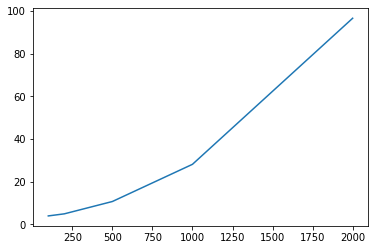

In [34]:
import matplotlib.pyplot as plt 
Ns = [100, 200, 500, 1000, 2000]
times = [ 3.99779508,  4.97144271, 10.74960744, 28.17204154, 96.59023686]
plt.plot(Ns,times)
# plt.xscale('log')
# plt.yscale('log')
plt.show()